<h2>IMPORTS

In [5]:
import os
import glob

import numpy as np
print('numpy: %s' % np.__version__)
import pandas as pd
print('pandas: %s' % pd.__version__)
import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)
import matplotlib
import seaborn as sns
import datetime
from datetime import date
import calendar
from calendar import monthrange
import holidays
from pandas_profiling import ProfileReport

%matplotlib inline

numpy: 1.19.2
pandas: 1.2.2
matplotlib: 1.19.2


<h2>Alle Dateien werden eingelesen und zum Dataframe hinzugefügt

In [6]:
list_df=[]
list_of_dates=[]
by_day_df = pd.DataFrame()

csv_files = glob.glob("*.csv")
csv_files.sort(key=os.path.getctime)

date_time_str = '2019-11-01 04:00:00'
date_time_start = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

date_time_str = '2019-11-01'
date_time_first = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_time_str = '2020-01-31'
date_time_end = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_list= pd.date_range(date_time_first , date_time_end, freq='D')


austria_holidays = holidays.CountryHoliday('AT', prov=1)

austria_holidays = austria_holidays['2019-11-01': '2020-11-01']

austria_holidays = date_list.isin(austria_holidays)

#Kapazität des Busmodells 15A - Mercedes Benz Citaro GNG 265 MB
kapaz = 129
    
for i, filename in enumerate (csv_files):
    
    #print(i, filename)
    
    #read the data and dont take the last column
    puffer_df= pd.read_csv(filename, index_col=None, header= 0,usecols=[0,1,2,3],decimal = ",", delimiter=";")

    #print(puffer_df)
    
    for k in range (4,25):

        if k == 24 :
            #Zeit ist statt 01:00 am nächsten Tag halt 23:59:59
            date_time_start = date_time_start.replace(hour = 23, minute = 59, second = 59)

        else:
            #Datum ist nun um eine Stunde vorgestellt
            date_time_start = date_time_start.replace(hour = k)

        #HIER muss es zugewiesen werden bevor die stunde wieder verändert wird
        list_of_dates.append(date_time_start)
            
        
    puffer_df.insert(0,'Datum',list_of_dates)
    list_of_dates.clear()

    last_of_month = monthrange(date_time_start.year, date_time_start.month)[1]  

    if date_time_start.month != 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(month = date_time_start.month + 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    elif date_time_start.month == 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(year = date_time_start.year +1, month = 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    else:
        date_time_start = date_time_start.replace(day = date_time_start.day + 1, hour = 4 , minute = 0, second = 0)
        
    #ENDE von Datum
    
    
    puffer_df.insert(1,'Wochentag',calendar.day_name[date_list[i].weekday()])
    puffer_df.insert(6,'Kapazität',puffer_df['Istfahrtenzahl']*kapaz)
    puffer_df.insert(7,'Feiertag',austria_holidays[i].astype(int))
    
    #vor dem Berechnen die NAN VALUES mit '0' ersetzen
    puffer_df.fillna(0, inplace = True)
    
    #stuff für die monats dataframe
    summe = puffer_df['P hochgerechnet'].sum()
    summesoll = puffer_df['Sollfahrtenzahl'].sum()
    summeist = puffer_df['Istfahrtenzahl'].sum()
    prozent = float(summeist/summesoll)*100
    kapaz_daily = summeist*kapaz
    

    row_month = {'Datum': date_list[i], 'Wochentag': calendar.day_name[date_list[i].weekday()],
                 'P hochgerechnet': summe, 'Sollfahrtenzahl':summesoll, 'Istfahrtenzahl':summeist,
                 'Genauigkeit':prozent,'Kapazität':kapaz_daily, 'Feiertag':austria_holidays[i].astype(int) }
    
    by_day_df = by_day_df.append(row_month , ignore_index = True)
    
    list_df.append(puffer_df) #!!!!
    
    by_hour_df = pd.concat(list_df, ignore_index = True)
    
    #print(puffer_df)
    #print(summe,summesoll,summeist,prozent)

by_day_df = by_day_df.reindex(columns=['Datum','Wochentag','P hochgerechnet','Sollfahrtenzahl','Istfahrtenzahl','Genauigkeit','Kapazität','Feiertag'])

In [8]:
by_day_df.to_excel('daily_values.xlsx')
by_hour_df.to_excel('hourly_values.xlsx')

In [14]:
print(by_day_df.keys())
print(by_day_df.head())

Index(['Datum', 'Wochentag', 'P hochgerechnet', 'Sollfahrtenzahl',
       'Istfahrtenzahl', 'Genauigkeit', 'Kapazität', 'Feiertag'],
      dtype='object')
       Datum Wochentag  P hochgerechnet  Sollfahrtenzahl  Istfahrtenzahl  \
0 2019-11-01    Friday      4936.608333            215.0           160.0   
1 2019-11-02  Saturday      6379.658333            224.0           172.0   
2 2019-11-03    Sunday      6260.500000            215.0           210.0   
3 2019-11-04    Monday     11992.383532            317.0           275.0   
4 2019-11-05   Tuesday     13416.813492            317.0           294.0   

   Genauigkeit  Kapazität  Feiertag  
0    74.418605    20640.0       1.0  
1    76.785714    22188.0       0.0  
2    97.674419    27090.0       0.0  
3    86.750789    35475.0       0.0  
4    92.744479    37926.0       0.0  


In [16]:
print(by_hour_df.keys())
print(by_hour_df.head())

Index(['Datum', 'Wochentag', 'Tageszeit', 'Sollfahrtenzahl', 'Istfahrtenzahl',
       'P hochgerechnet', 'Kapazität', 'Feiertag'],
      dtype='object')
                Datum Wochentag      Tageszeit  Sollfahrtenzahl  \
0 2019-11-01 04:00:00    Friday  04:00 - 04:59                4   
1 2019-11-01 05:00:00    Friday  05:00 - 05:59               10   
2 2019-11-01 06:00:00    Friday  06:00 - 06:59                8   
3 2019-11-01 07:00:00    Friday  07:00 - 07:59                8   
4 2019-11-01 08:00:00    Friday  08:00 - 08:59               12   

   Istfahrtenzahl  P hochgerechnet  Kapazität  Feiertag  
0               4        30.000000        516         1  
1               7        87.083333        903         1  
2               6        95.333333        774         1  
3               6        97.333333        774         1  
4               8       195.000000       1032         1  


In [20]:
print("Stündliche Daten:\n",by_hour_df.describe())
print("Tägliche Daten:\n",by_day_df.describe())

Stündliche Daten:
        Sollfahrtenzahl  Istfahrtenzahl  P hochgerechnet    Kapazität  \
count      1932.000000     1932.000000      1932.000000  1932.000000   
mean         13.368012       11.747412       863.542180  1515.416149   
std           4.269734        4.932309       651.001529   636.267877   
min           4.000000        0.000000         0.000000     0.000000   
25%          10.000000        8.000000       308.173199  1032.000000   
50%          13.000000       12.000000       756.525953  1548.000000   
75%          16.000000       16.000000      1308.095472  2064.000000   
max          23.000000       23.000000      3196.918908  2967.000000   

          Feiertag  
count  1932.000000  
mean      0.065217  
std       0.246973  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  
Tägliche Daten:
        P hochgerechnet  Sollfahrtenzahl  Istfahrtenzahl  Genauigkeit  \
count        92.000000        92.000000       92.00000

In [77]:
print("INFO")
print(by_day_df.info())
print(by_hour_df.info())

print("NULL VALUES?") 
print(by_day_df.isnull())
print(by_hour_df.isnull())

print("by_day")
print(np.where(pd.isnull(by_day_df)))
print("by_hour")
print(np.where(pd.isnull(by_hour_df)))

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Datum            92 non-null     datetime64[ns]
 1   Wochentag        92 non-null     object        
 2   P hochgerechnet  92 non-null     float64       
 3   Sollfahrtenzahl  92 non-null     float64       
 4   Istfahrtenzahl   92 non-null     float64       
 5   Genauigkeit      92 non-null     float64       
 6   Kapazität        92 non-null     float64       
 7   Feiertag         92 non-null     float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 5.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932 entries, 0 to 1931
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Datum            1932 non-null   datetime64[ns]
 1   Wochentag        

In [ ]:
by_day_df.plot(x="Datum", y="Genauigkeit", kind= "line")

In [9]:
genauigkeits_summe = by_day_df['Genauigkeit'].mean()
print(genauigkeits_summe)

87.93041475748147


In [ ]:
##profile report für STUNDEN

report = ProfileReport(by_hour_df, title='Pandas Profiling Report')

report.to_widgets()

In [ ]:
#profile report für TAGE

report = ProfileReport(by_day_df, title='Pandas Profiling Report')

report.to_widgets()

<h2>Density plot

<AxesSubplot:ylabel='Density'>

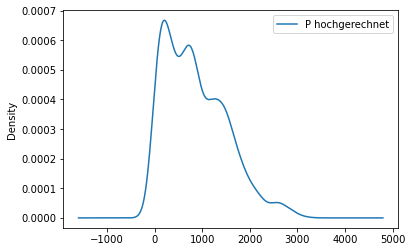

In [21]:
by_hour_df.plot(x="Datum", y="P hochgerechnet", kind= "kde")

<AxesSubplot:ylabel='Density'>

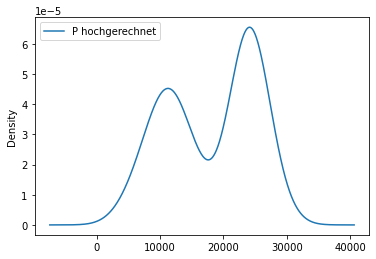

In [22]:
by_day_df.plot(x="Datum", y="P hochgerechnet", kind= "kde")

<AxesSubplot:>

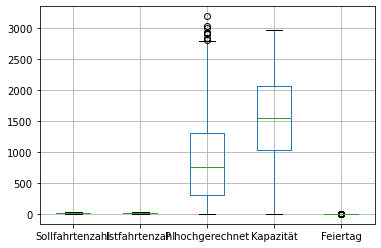

In [23]:
by_hour_df.boxplot()

<h2>Kapzität gegenübergestellt mit Passagier-eingängen

<h3>Stündlich

<AxesSubplot:xlabel='Datum'>

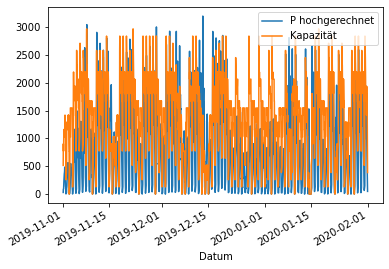

In [25]:
by_hour_df.plot(x="Datum", y=["P hochgerechnet", "Kapazität"], kind= "line")

<h3> Täglich

<AxesSubplot:xlabel='Datum'>

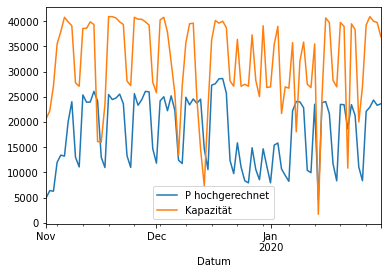

In [26]:
by_day_df.plot(x="Datum", y=["P hochgerechnet", "Kapazität"], kind= "line")

<h2> Subplot: Alle Eigenschaften in einer Plot

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

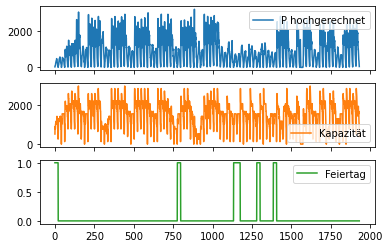

In [27]:
by_hour_df_smaller = by_hour_df.drop(columns= ["Datum","Tageszeit","Sollfahrtenzahl","Istfahrtenzahl"])

by_hour_df_smaller.plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

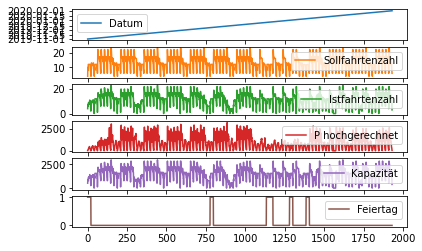

In [28]:
by_hour_df.plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

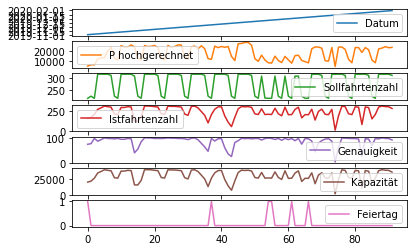

In [29]:
by_day_df.plot(subplots=True)

<h2>Histogram plot - Verteilung der Werte

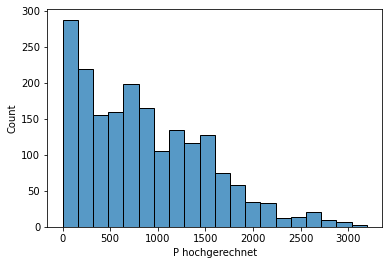

In [30]:
sns.histplot(by_hour_df["P hochgerechnet"])
plt.show()

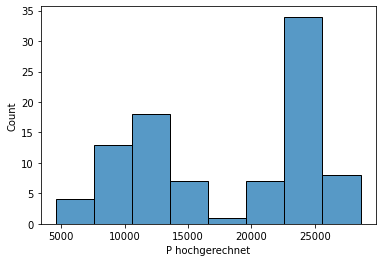

In [31]:
sns.histplot(by_day_df["P hochgerechnet"])
plt.show()

<h2> Lag Plot - zur Sicherstellung der zeitlichen Chronologie

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

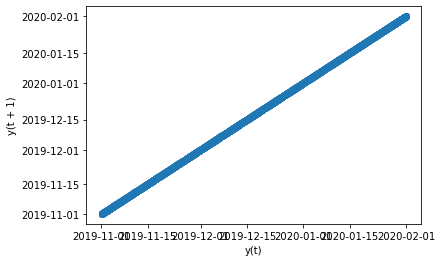

In [32]:
from pandas.plotting import lag_plot

plt.figure()

lag_plot(by_hour_df["Datum"])

<h2> Autocorrelation - notwendig für ARIMA Modell

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

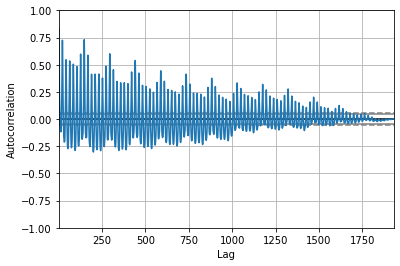

In [33]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(by_hour_df["P hochgerechnet"])

<h2> Partial Autocorrelation - notwendig für ARIMA Modell

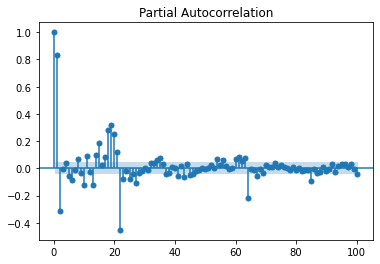

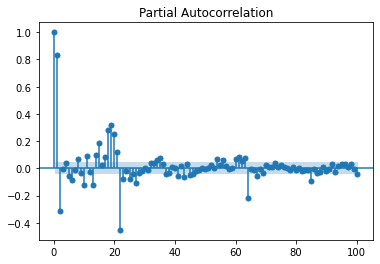

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(by_hour_df["P hochgerechnet"], lags=100)

<h1>Line Plot Stündlich nach Tageszeit

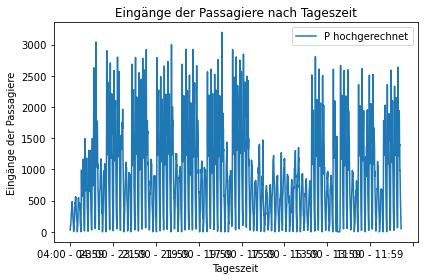

In [38]:
by_hour_df.plot(x="Tageszeit", y="P hochgerechnet", kind="line")

plt.title("Eingänge der Passagiere nach Tageszeit") 
plt.legend()
plt.xlabel('Tageszeit') 
plt.ylabel('Eingänge der Passagiere') 
plt.tight_layout()

plt.show()

<h2>Scatter Plot Eingänge vs Kapazität

<AxesSubplot:xlabel='P hochgerechnet', ylabel='Kapazität'>

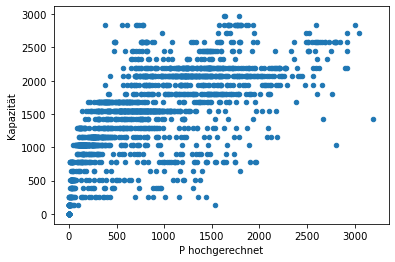

In [39]:
by_hour_df.plot(x= "P hochgerechnet", y="Kapazität", kind="scatter")

<h2>Scatter Plot Eingänge vs Wochentag

<AxesSubplot:xlabel='Wochentag', ylabel='P hochgerechnet'>

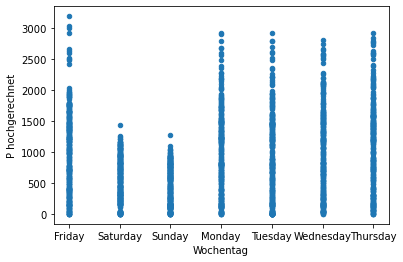

In [40]:
by_hour_df.plot(x= "Wochentag", y="P hochgerechnet", kind="scatter")

<h2> Decomposing the Data: Trend, Seasonality

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

#by_hour_df mit by_day_df eretzen um Tage zu sehen, P hochgerechnet

decompose = by_hour_df.set_index("Datum")

print(decompose["P hochgerechnet"])

#period = Anzahl der Beobachtungen/2
result = seasonal_decompose(decompose["P hochgerechnet"], model='additive', period= 966)
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

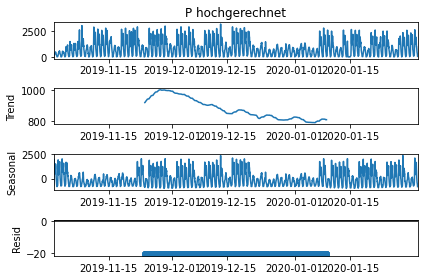

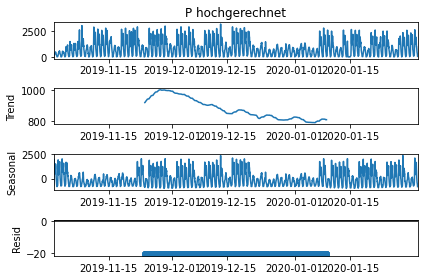

In [43]:
result.plot()